# SIDS application --- NorthCarolina

### References

* See https://r-spatial.github.io/spdep/articles/sids.html

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Version Information

In [2]:
import echelon

import matplotlib
# For some reason, NetworkX plot functionality (nx.draw()) seems to fail with a newer matplotlib:
# https://stackoverflow.com/questions/63198347/attributeerror-module-matplotlib-cbook-has-no-attribute-iterable
assert matplotlib.__version__ =='2.2.3'

from echelon.contrib.geo import required_modules

for module in [echelon, matplotlib] + required_modules:
    print(module.__name__, module.__version__)

echelon 1.0.3
matplotlib 2.2.3
geopandas 0.10.2
libpysal 4.5.1


## Downloading Data

In [3]:
import urllib.request
from pathlib import Path
import zipfile
import shutil

data_dir = Path('data/application-SIDS-NorthCarolina')
data_dir.mkdir(exist_ok=True, parents=True)

_filename = data_dir / 'sids.zip'
if not _filename.exists():
    urllib.request.urlretrieve('https://geodacenter.github.io/data-and-lab//data/sids.zip', _filename)

if not (data_dir / 'sids').exists():
    with zipfile.ZipFile(_filename) as _f:
        _f.extractall(data_dir)

    for _p in (data_dir / 'sids').glob("*"):
        shutil.move(str(_p), str(data_dir))

print([a.name for a in (data_dir).iterdir()])

['sids.shx', 'sids.shp', 'sids.gdb', 'sids.dbf', 'sids.sqlite', 'sids.csv', '__MACOSX', 'sids.xlsx', 'sids.prj', 'sids.html', 'sids.zip', 'sids.kml', 'sids.geojson', 'sids', 'sids.gpkg']


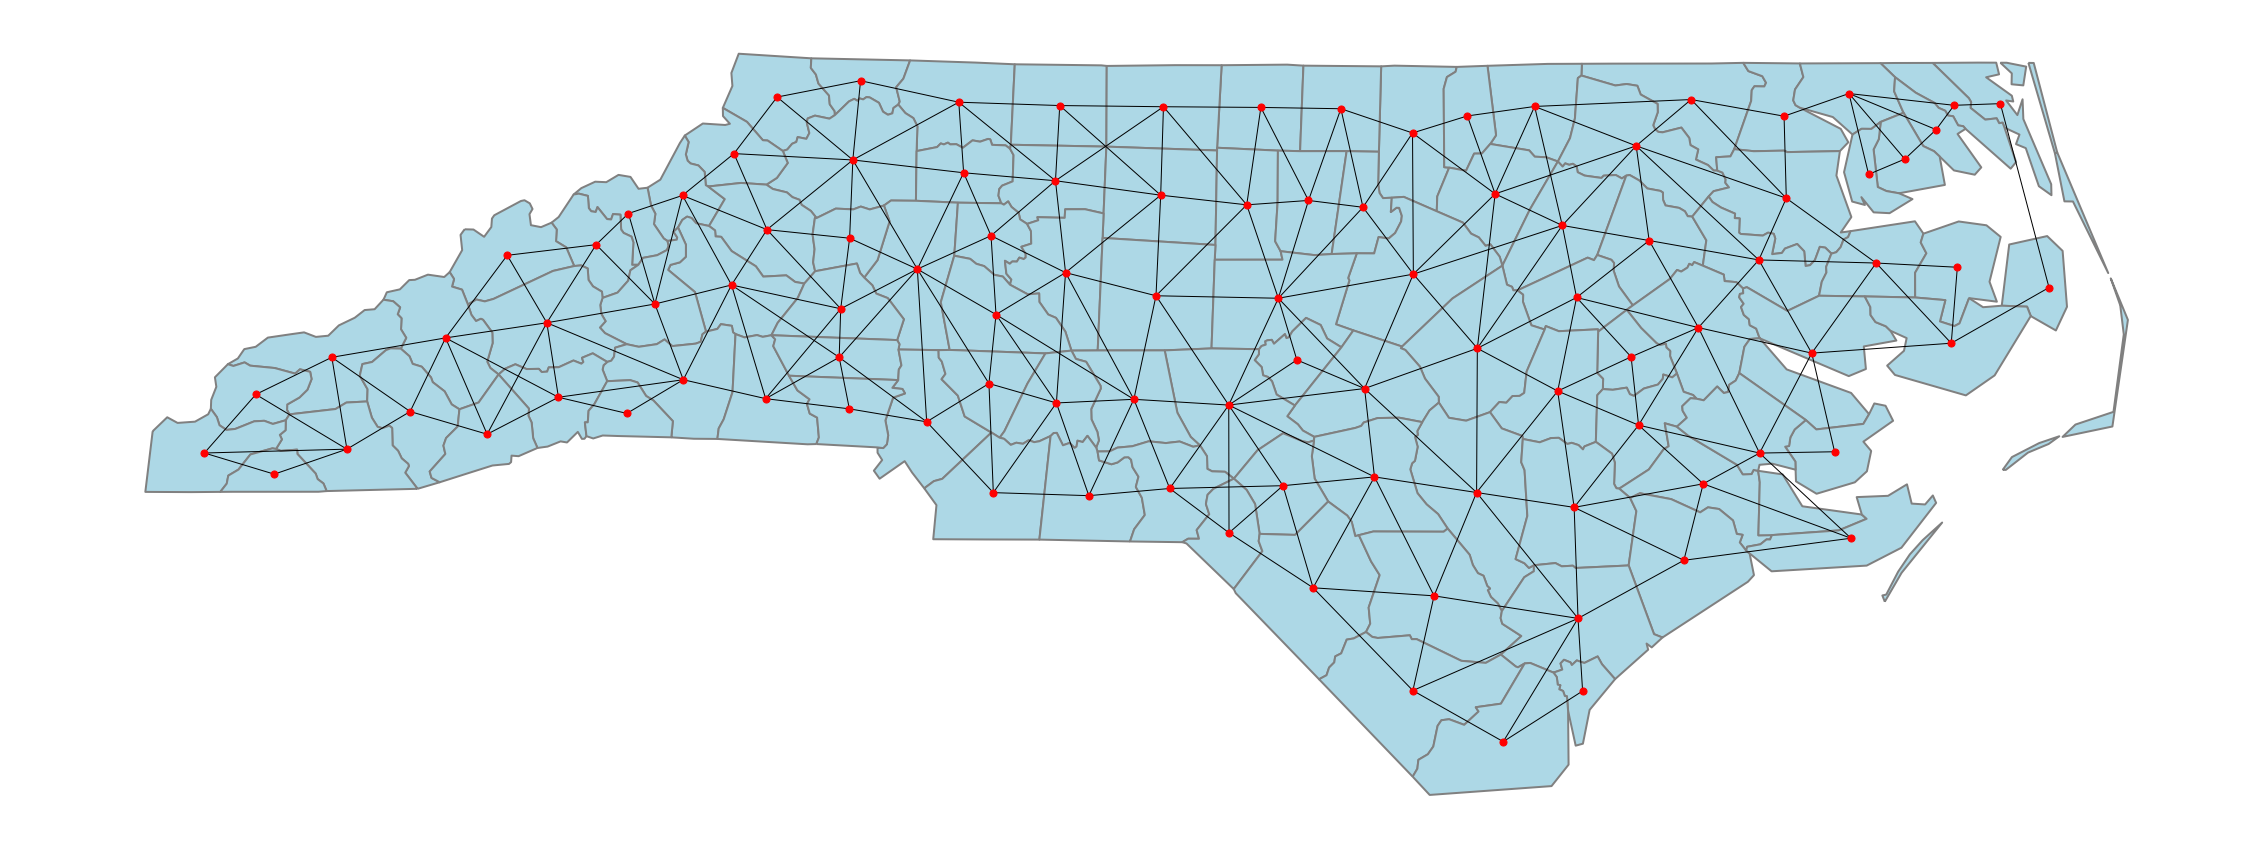

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd

from echelon.api import DataFrameEchelonAnalysis
from echelon.contrib.geo import GISAdjacency
from echelon.contrib.geo import GISPlotter


df = pd.read_csv(data_dir / 'sids.csv',
                 dtype={
                     'BIR74': 'Int64',
                     'SID74': 'Int64',
                     'NWBIR74': 'Int64',
                     'BIR79': 'Int64',
                     'SID79': 'Int64',
                     'NWBIR79': 'Int64',
                 }
                )
df['cas'] = df['SID74'] + df['SID79']
df['pop'] = df['BIR74'] + df['BIR79']
df['rate'] = df['cas'] * 1000 / df['pop']

adjacency = GISAdjacency.from_shapefile(data_dir / 'sids.shp', id_colname='NAME')
## Plot adjacency graph
import matplotlib.pyplot as plt
adjacency.plot()
plt.show()

adj_series = adjacency.to_series()
# display(df)
df = df.merge(adj_series)

# from IPython.display import display
# display(adj_series)

## Construct Echelon
analyzer = DataFrameEchelonAnalysis()
result = analyzer(df, 'rate', 'NAME', 'adjacency')

## Scan hot spots
hotspots = analyzer.hotspots(result, data=(df, 'NAME', 'cas', 'pop'), score='binomial')

## Plot hot spots
#GISPlotter(, 'name').plot_hotspot(hotspots, label_col='name', nth=1, id_col='SIKUCHOSON')

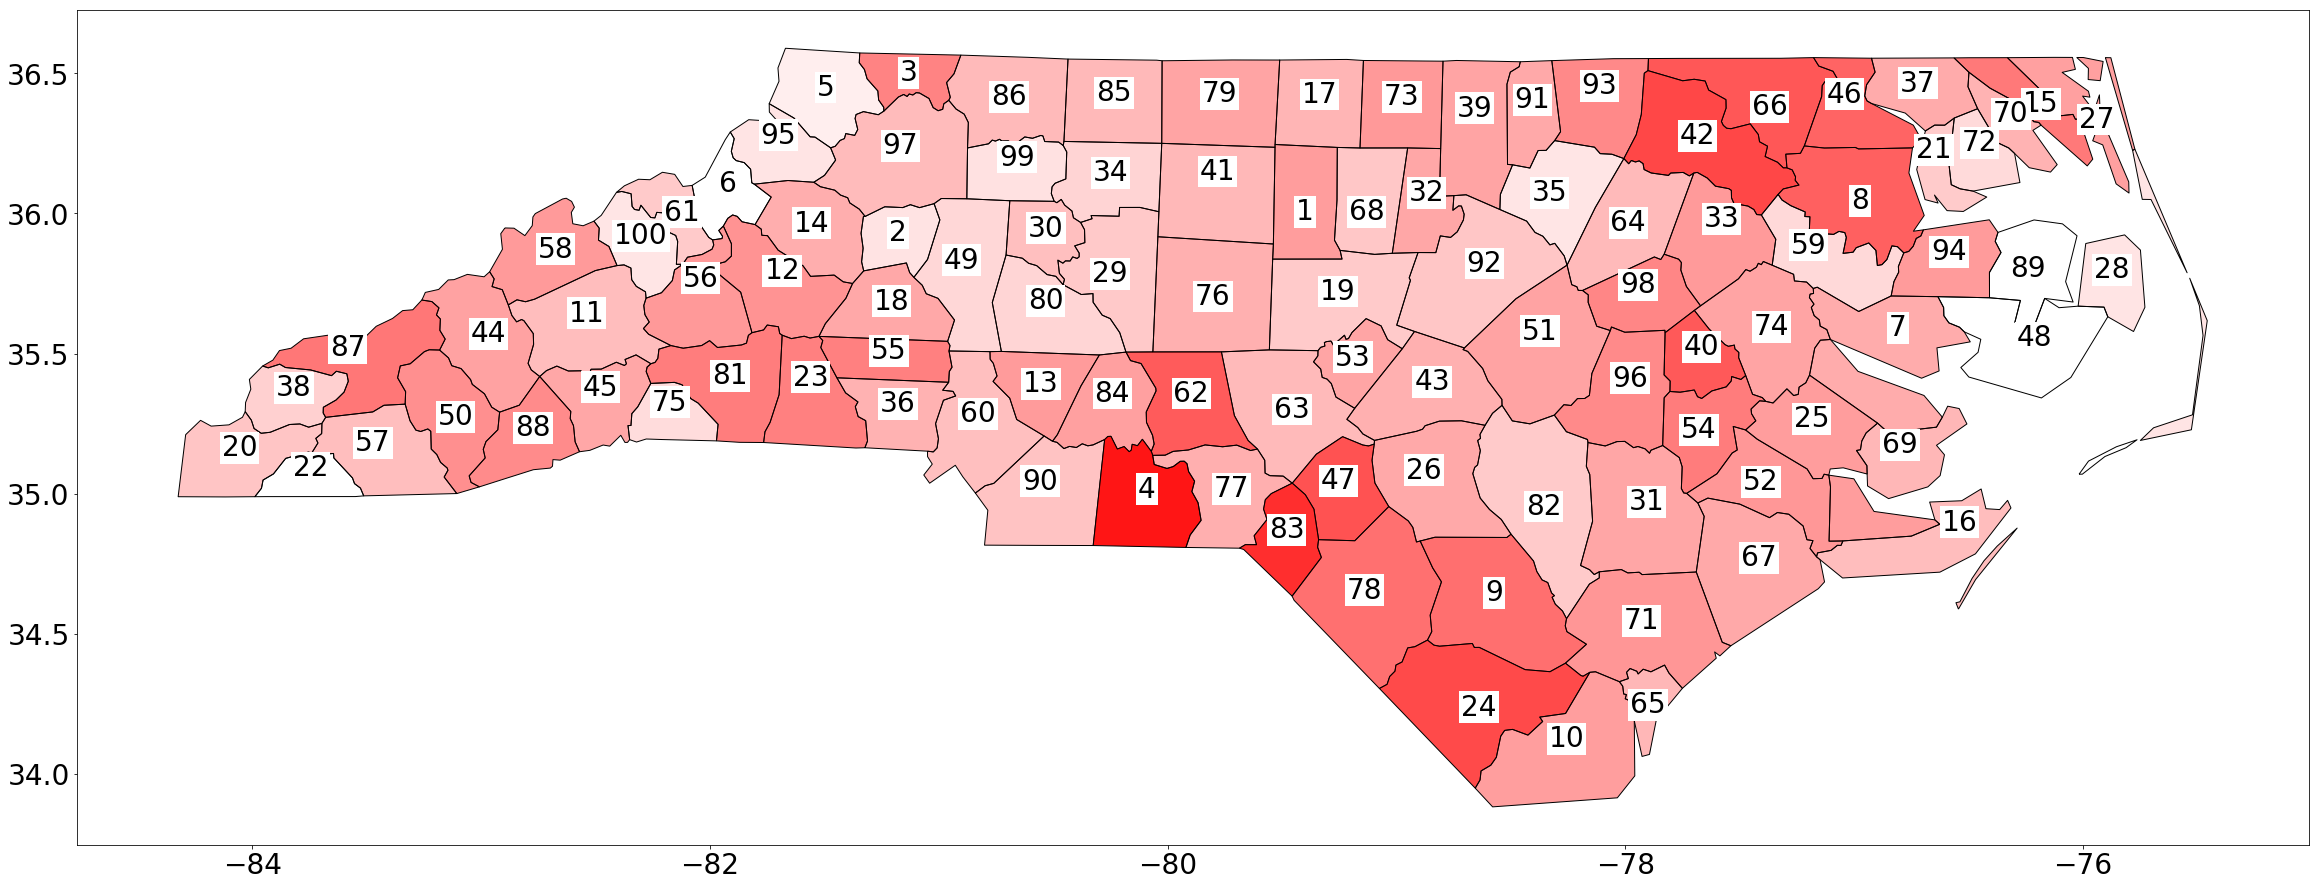

In [5]:
plotter = GISPlotter(pd.concat((adjacency.gdf, df), axis=1), name_col='CRESS_ID')
#plotter.gdf['rate']
plotter.plot_values('rate', lambda v: (v / 6))
None

In [6]:
print(analyzer.dendrogram(result))

E31(Davidson): [Tyrrell, Clay, Avery, Hyde, Ashe, Yancey, Franklin, Dare, Watauga, Alexander, Yadkin, Polk, Perquimans, Martin, Iredell, Rowan, Forsyth, Graham, Chowan, Sampson, Chatham, Mitchell, Davidson]
 (max: 1.2646221941195068)

├── E30(Wilkes): [Orange, Wake, Cherokee, Union, Mecklenburg, Macon, Buncombe, Carteret, Wilkes]
│    (max: 1.6009314510260515)
│   
│   ├── E29(Surry): [Surry]
│   │    (max: 1.6166960611405057)
│   │   
│   │   ├── E28(Harnett): [Moore, Nash, Stokes, Guilford, New Hanover, Pamlico, Caswell, Pasquotank, Harnett]
│   │   │    (max: 1.8680677174547577)
│   │   │   
│   │   │   ├── E27(Randolph): [Randolph]
│   │   │   │    (max: 1.868791187174191)
│   │   │   │   
│   │   │   │   ├── E26(Richmond): [Richmond]
│   │   │   │   │    (max: 1.8758526603001364)
│   │   │   │   │   
│   │   │   │   │   ├── E25(Gates): [Beaufort, Gates]
│   │   │   │   │   │    (max: 1.9723865877712032)
│   │   │   │   │   │   
│   │   │   │   │   │   ├── E24(Vance): [Onslow, Vanc

In [7]:
df

,AREA,PERIMETER,CNTY_,CNTY_ID,NAME,FIPS,FIPSNO,CRESS_ID,BIR74,SID74,NWBIR74,BIR79,SID79,NWBIR79,cas,pop,rate,adjacency
0,0.114,1.442,1825,1825,Ashe,37009,37009,5,1091,1,10,1364,0,19,1,2455,0.407332,"[Wilkes, Watauga, Alleghany]"
1,0.061,1.231,1827,1827,Alleghany,37005,37005,3,487,0,10,542,3,12,3,1029,2.915452,"[Ashe, Wilkes, Surry]"
2,0.143,1.630,1828,1828,Surry,37171,37171,86,3188,5,208,3616,6,260,11,6804,1.616696,"[Alleghany, Wilkes, Yadkin, Forsyth, Stokes]"
3,0.070,2.968,1831,1831,Currituck,37053,37053,27,508,1,123,830,2,145,3,1338,2.242152,"[Camden, Dare]"
4,0.153,2.206,1832,1832,Northampton,37131,37131,66,1421,9,1066,1606,3,1197,12,3027,3.964321,"[Warren, Bertie, Hertford, Halifax]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.225,2.107,2162,2162,Bladen,37017,37017,9,1782,8,818,2052,5,1023,13,3834,3.390715,"[Pender, Cumberland, Columbus, Robeson, Sampson]"
96,0.214,2.152,2185,2185,Pender,37141,37141,71,1228,4,580,1602,3,763,7,2830,2.473498,"[Columbus, New Hanover, Brunswick, Duplin, Ons..."
97,0.240,2.365,2232,2232,Columbus,37047,37047,24,3350,15,1431,4144,17,1832,32,7494,4.270083,"[Pender, Brunswick, Robeson, Bladen]"
98,0.042,0.999,2238,2238,New Hanover,37129,37129,65,5526,12,1633,6917,9,2100,21,12443,1.687696,"[Pender, Brunswick]"
